## Topic Modeling with LDA

In this section we develop a topic model using Latent Dirichlet Allocation (LDA) to discover unobserved themes across papers. This may have practical value in the following ways: 

1. Uncovering nontrivial relationships between disparate fields of research 
2. Organizing papers into useful categories
3. Navigating citations based on their usage in papers within & across categories

#### Step 1: Import & Preprocess Data

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.manifold import TSNE
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from datasets import load_dataset
from natsort import natsort_keygen

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mattroth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [185]:
# Load pubmed dataset from huggingface
articles = load_dataset("scientific_papers", "pubmed", split="validation")
df_articles = pd.DataFrame(articles)

Found cached dataset scientific_papers (/Users/mattroth/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f)


In [186]:
# Inspect df_articles
df_articles.head()

,article,abstract,section_names
0,"approximately , one - third of patients with s...",background and aim : there is lack of substan...,Introduction\nSubjects and Methods\nResults\nD...
1,there is an epidemic of stroke in low and midd...,backgroundthe questionnaire for verifying str...,1. Introduction\n2. Methods\n2.1. Study sites\...
2,\n cardiovascular diseases account for the hig...,\n background : timely access to cardiovascul...,Introduction\nMethods\nResults\nDiscussion\nCo...
3,results of a liquid culturing system ( bd bact...,to determine differences in the ability of my...,The Study\nConclusions\nSupplementary Material
4,the need for magnetic resonance imaging ( mri ...,aimsour aim was to evaluate the potential for...,Introduction\nMethods\nPatient selection\nMagn...


In [187]:
# Lemmatize article text
lem = WordNetLemmatizer()
def lemmatize_text(text):
    return [lem.lemmatize(w) for w in tokenizer.tokenize(text)]

df_articles['article_lemmatized'] = df_articles["article"].apply(lambda x: lemmatize_text(x))
df_articles["article_lemmatized"] = df_articles["article_lemmatized"].apply(lambda x: " ".join(x))

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(
    "(?:(?<=\s)|(?<=^)|(?<=[>\"]))[a-z-']+(?:(?=\s)|(?=\:\s)|(?=$)|(?=[.!,;\"]))"
)

# Create custom stop words set with units and others
custom_stop_words = text.ENGLISH_STOP_WORDS.union([
    "et","al", # from et al
    "mg","g","kg","lb", # mass / weight
    "ml","l","dl","oz", # volume
    "nm","mm","cm","m","ft", # length
    "c","f" # temperature
    ])

# Encode data with TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=list(custom_stop_words),
                        max_df=0.90, # ignore words occuring in more than this % of docs
                        min_df=0.02, # ignore words occuring in less than this % of docs
                        max_features=1000,
                        tokenizer=tokenizer.tokenize)
vectorized_articles = tfidf.fit_transform(df_articles["article_lemmatized"])

# Save vocab
vocab = tfidf.get_feature_names_out()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Step 2: Run LDA

In [195]:
# Instantiate LDA
n_topics = 10
lda = LDA(n_components=n_topics)

# Run on vectorized_articles
X_topics = lda.fit_transform(vectorized_articles)

In [196]:
# Get topic distribution
topic_words = lda.components_

# Retrieve topics
for i, topic_dist in enumerate(topic_words):
    
    # Zip vocab and topic distribution
    zipped = zip(vocab, topic_dist)

    # Sort and get out top 10 words for each topic
    top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[0:10]
    top_terms_list = list(dict(top_terms_key).keys())

    # Print
    print(f"Topic {i + 1}: {top_terms_list}")
    

Topic 1: ['patient', 'surgery', 'bone', 'fracture', 'teeth', 'procedure', 'surgical', 'case', 'pain', 'technique']
Topic 2: ['hz', 'j', 'nmr', 'h', 'mhz', 'mmol', 'd', 's', 'compound', 'solid']
Topic 3: ['implant', 'bone', 'surgical', 'complication', 'surgery', 'behavior', 'mediated', 'pcr', 'dental', 'chronic']
Topic 4: ['virus', 'strain', 'pcr', 'genotype', 'infection', 'viral', 'sequence', 'gene', 'sample', 'infected']
Topic 5: ['protein', 'sample', 'using', 'figure', 'sequence', 'specie', 'solution', 'water', 'gene', 'surface']
Topic 6: ['patient', 'study', 'group', 'p', 'subject', 'diabetes', 'score', 'age', 'test', 'level']
Topic 7: ['tumor', 'lesion', 'patient', 'case', 'cell', 'ct', 'mass', 'right', 'left', 'diagnosis']
Topic 8: ['health', 'study', 'patient', 'care', 'child', 'data', 'year', 'hospital', 'risk', 'service']
Topic 9: ['patient', 'case', 'day', 'treatment', 'infection', 'disease', 'therapy', 'blood', 'symptom', 'renal']
Topic 10: ['cell', 'expression', 'mouse', 'ge

In [197]:
# Assign topics to articles
article_topics = lda.transform(vectorized_articles)

topics = []
for i in range(article_topics.shape[0]):

    # Get most likely topic for each article
    topic = article_topics[i].argmax() + 1
    topics.append(topic)

# Add columns to df_articles
df_articles["main_topic"] = topics
for i in range(article_topics.shape[1]):
    df_articles[f"topic{i+1}_prob"] = article_topics[:,i]

In [198]:
# Inspect df_articles with topic
df_articles.head()

,article,abstract,section_names,article_lemmatized,main_topic
0,"approximately , one - third of patients with s...",background and aim : there is lack of substan...,Introduction\nSubjects and Methods\nResults\nD...,approximately one - third of patient with symp...,9
1,there is an epidemic of stroke in low and midd...,backgroundthe questionnaire for verifying str...,1. Introduction\n2. Methods\n2.1. Study sites\...,there is an epidemic of stroke in low and midd...,6
2,\n cardiovascular diseases account for the hig...,\n background : timely access to cardiovascul...,Introduction\nMethods\nResults\nDiscussion\nCo...,cardiovascular disease account for the highest...,8
3,results of a liquid culturing system ( bd bact...,to determine differences in the ability of my...,The Study\nConclusions\nSupplementary Material,result of a liquid culturing system bd bactec ...,5
4,the need for magnetic resonance imaging ( mri ...,aimsour aim was to evaluate the potential for...,Introduction\nMethods\nPatient selection\nMagn...,the need for magnetic resonance imaging mri in...,7


#### Step 3: Latent Topic Analysis

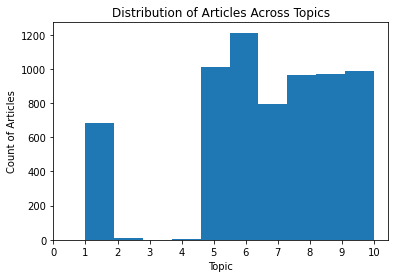

In [206]:
# View distribution of articles over topics
plt.hist(df_articles["main_topic"], bins=n_topics)
plt.xticks(np.arange(0, n_topics+1, 1.0))
plt.xlabel("Topic")
plt.ylabel("Count of Articles")
plt.title("Distribution of Articles Across Topics")
plt.show()

In [200]:
# Visualize topic relevance for each topic over all docs


<AxesSubplot: xlabel='x', ylabel='y'>

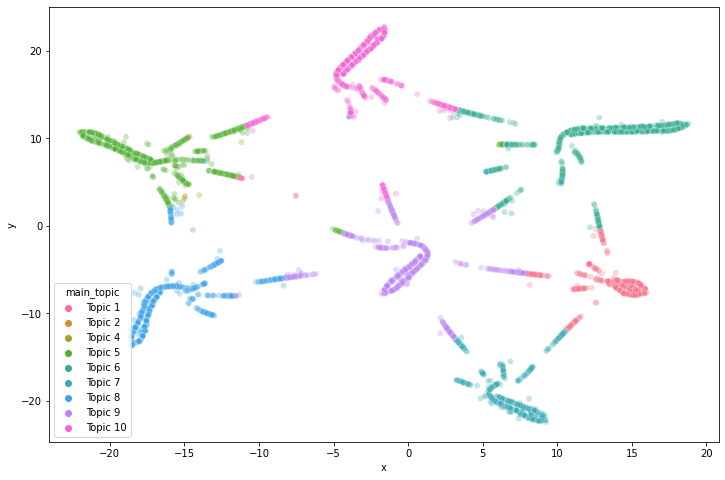

In [218]:
# Visualize topic distributions with t-SNE
tsne = TSNE(perplexity=400)
tsne_results = tsne.fit_transform(article_topics)
embedding = pd.DataFrame(tsne_results, columns=['x','y'])
embedding["main_topic"] = [f"Topic {t + 1}" for t in article_topics.argmax(axis=1)]
embedding.sort_values("main_topic", ascending=True, key=natsort_keygen(), inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(
    data=embedding,
    x="x", 
    y="y",
    hue="main_topic",
    palette=sns.color_palette("husl", embedding["main_topic"].nunique()),    
    legend="full",
    alpha=0.3
)
